In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
north = pd.read_csv('Climatology_Northern_Hemisphere.csv')
south = pd.read_csv('Climatology_Southern_Hemisphere.csv')

In [4]:
df_8north = north.groupby('ID').head(8).reset_index(drop=True)
df_8south = south.groupby('ID').head(8).reset_index(drop=True)

north1 = df_8north.dropna() 
south1 = df_8south.dropna()

north = north1.groupby('ID').filter(lambda x: len(x) >= 8)
south = south1.groupby('ID').filter(lambda x: len(x) >= 8)

In [5]:
from sklearn.preprocessing import StandardScaler

lon_scaler = StandardScaler()
lat_scaler = StandardScaler()

all_lons = np.concatenate([north['lon'], south['lon']])
all_lats = np.concatenate([north['lat'], south['lat']])

lon_scaler.fit(all_lons.reshape(-1, 1))
lat_scaler.fit(all_lats.reshape(-1, 1))


def create_sequences(group, lon_scaler, lat_scaler):
    features = ['lon', 'lat', 'rel_vort_850_smth', 'vortex_diameter', 
               'theta_trop_mean250', 'theta_diff_500-sst_mean250', 
               'shear_angle_925-500_mean250', 'shear_strength_925-500_mean250', 
               'slp', 'SST-T_500_mean250']
    
    # Scale all features
    scaled_lon = lon_scaler.transform(group['lon'].values.reshape(-1, 1))
    scaled_lat = lat_scaler.transform(group['lat'].values.reshape(-1, 1))
    
    feature_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(group[features])
    
    # Combine scaled coordinates and features
    scaled_data = np.hstack([scaled_lon, scaled_lat, scaled_features])
    
    return scaled_data
def create_sequences_wrapper(group):
    return create_sequences(group, lon_scaler, lat_scaler)

sequences_n = north.groupby('ID', group_keys=False).apply(create_sequences_wrapper)
X_n = np.stack(sequences_n.values)

sequences_s = south.groupby('ID', group_keys=False).apply(create_sequences_wrapper)
X_s = np.stack(sequences_s.values)

C:\Users\User\AppData\Local\Temp\ipykernel_11460\2917093288.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sequences_n = north.groupby('ID', group_keys=False).apply(create_sequences_wrapper)
C:\Users\User\AppData\Local\Temp\ipykernel_11460\2917093288.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sequences_s = south.groupby('ID', group_keys=False).apply(create_sequences_wrapper)


In [6]:
X = np.vstack((X_n, X_s))

In [17]:
target_steps = 7
input_steps = 8 - target_steps


X_initial = X[:, :input_steps, :]
y_target = X[:, input_steps:input_steps+target_steps, :2]

n_features = X_initial.shape[-1]
scaler = StandardScaler()

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model

tf.keras.backend.set_floatx('float64')
def transformer_model(input_shape, target_steps):
    inputs = Input(shape=input_shape, dtype='float64')
    
    # Self-Attention Layer
    attn = MultiHeadAttention(num_heads=4, key_dim=input_shape[-1])(inputs, inputs)
    attn = LayerNormalization(epsilon=1e-6)(inputs + attn)
    
    # Feed-Forward Network
    ff = Dense(64, activation="relu")(attn)
    ff = Dense(input_shape[-1])(ff)
    ff = LayerNormalization(epsilon=1e-6)(attn + ff)
    
    # Output layer - predict target_steps of (lon,lat) pairs
    outputs = TimeDistributed(Dense(2, dtype = 'float64'))(ff[:, -target_steps:, :])  # Only last target_steps steps
    
    return Model(inputs, outputs)

model = transformer_model(input_shape=(input_steps, X_initial.shape[-1]), target_steps=target_steps)
model.compile(optimizer='adam', loss='huber')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 12)     │      2,460 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1, 12)     │          0 │ input_layer_1[0]… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 12)     │         24 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 64)     │        832 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 12)     │        780 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1, 12)     │          0 │ layer_normalizat… │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 12)     │         24 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 1, 12)     │          0 │ layer_normalizat… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 1, 2)      │         26 │ get_item_1[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,146 (32.39 KB)

 Trainable params: 4,146 (32.39 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_initial, y_target, test_size=0.2)

In [42]:
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32
)

Epoch 1/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 2/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0040 - val_loss: 0.0049
Epoch 3/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 4/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 5/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 6/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 7/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0044 - val_loss: 0.0053
Epoch 8/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 9/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 10/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0040 - val_loss: 0.0051
Epoch 11/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0041 - val_loss: 0.0052
Epoch 12/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

In [ ]:
def predict_trajectory(model, initial_conditions, steps=target_steps):
    """Predict future (lon, lat) from initial conditions."""
    trajectory = []
    current_input = initial_conditions[np.newaxis, ...]  # Shape: (1, 5, n_features)
    
    for _ in range(steps):
        next_pred = model.predict(current_input)[0]  # Shape: (5, 2)
        trajectory.append(next_pred[-1])  # Take last predicted (lon, lat)
        # Update input (shift window)
        current_input = np.roll(current_input, -1, axis=1)
        current_input[0, -1, :2] = next_pred[-1]  # Replace last (lon, lat)
    
    return np.array(trajectory)

In [ ]:
def predict_trajectory(model, initial_conditions, steps):
    """
    Predict future trajectory while maintaining feature dimensions
    
    Args:
        model: Trained model
        initial_conditions: Initial input (input_steps, n_features)
        steps: Number of steps to predict
        n_features: Total number of features in input
        
    Returns:
        Array of predicted coordinates (steps, 2)
    """
    trajectory = []
    current_input = initial_conditions[np.newaxis, ...]  # Shape: (1, input_steps, n_features)
    
    for _ in range(steps):
        # Predict next steps (all features)
        next_pred = model.predict(current_input, verbose=0)[0]  # Shape: (input_steps, n_features)
        
        # Store just the coordinates (first two features)
        trajectory.append(next_pred[-1, :2])  # Shape: (2,)
        
        # Prepare next input - maintain all features
        current_input = np.roll(current_input, -1, axis=1)
        
        # Only update the coordinate features in the input
        # Keep other features from the original data
        current_input[0, -1, :2] = next_pred[-1, :2]  # Only update lon/lat
    
    return np.array(trajectory)  # Shape: (steps, 2)

# Now run the prediction and plotting

# Plotting function
def plot_trajectory_comparison(true_coords, predicted_coords, 
                             lon_scaler=None, lat_scaler=None,
                             input_steps=5, target_steps=3):
    """Plot trajectory comparison"""
    plt.figure(figsize=(12, 8))
    
    # Denormalize if scalers provided
    def denormalize(coords):
        if lon_scaler and lat_scaler:
            lon = lon_scaler.inverse_transform(coords[:,0].reshape(-1, 1))
            lat = lat_scaler.inverse_transform(coords[:,1].reshape(-1, 1))
            return np.column_stack((lon, lat))
        return coords
    
    true_coords = denormalize(true_coords)
    predicted_coords = denormalize(predicted_coords)
    
    # Split true trajectory
    input_coords = true_coords[:input_steps]
    true_future = true_coords[input_steps:input_steps+target_steps]
    
    # Plotting
    plt.plot(input_coords[:,0], input_coords[:,1], 'go-', linewidth=2, markersize=8, label='Input Sequence')
    plt.plot(true_future[:,0], true_future[:,1], 'bo-', linewidth=2, markersize=8, label='True Future')
    plt.plot(predicted_coords[:,0], predicted_coords[:,1], 'ro--', linewidth=2, markersize=8, label='Predicted')
    
    # Connect last input to first prediction
    plt.plot([input_coords[-1,0], predicted_coords[0,0]],
             [input_coords[-1,1], predicted_coords[0,1]], 'k--', alpha=0.3)
    
    # Annotate points
    for i, (lon, lat) in enumerate(input_coords):
        plt.text(lon, lat, f'I{i+1}', fontsize=10, ha='right', va='bottom')
    for i, (lon, lat) in enumerate(true_future):
        plt.text(lon, lat, f'T{i+1}', fontsize=10, ha='right', va='bottom')
    for i, (lon, lat) in enumerate(predicted_coords):
        plt.text(lon, lat, f'P{i+1}', fontsize=10, ha='left', va='top')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Trajectory Prediction Comparison')
    plt.legend()
    plt.grid()
    plt.show()


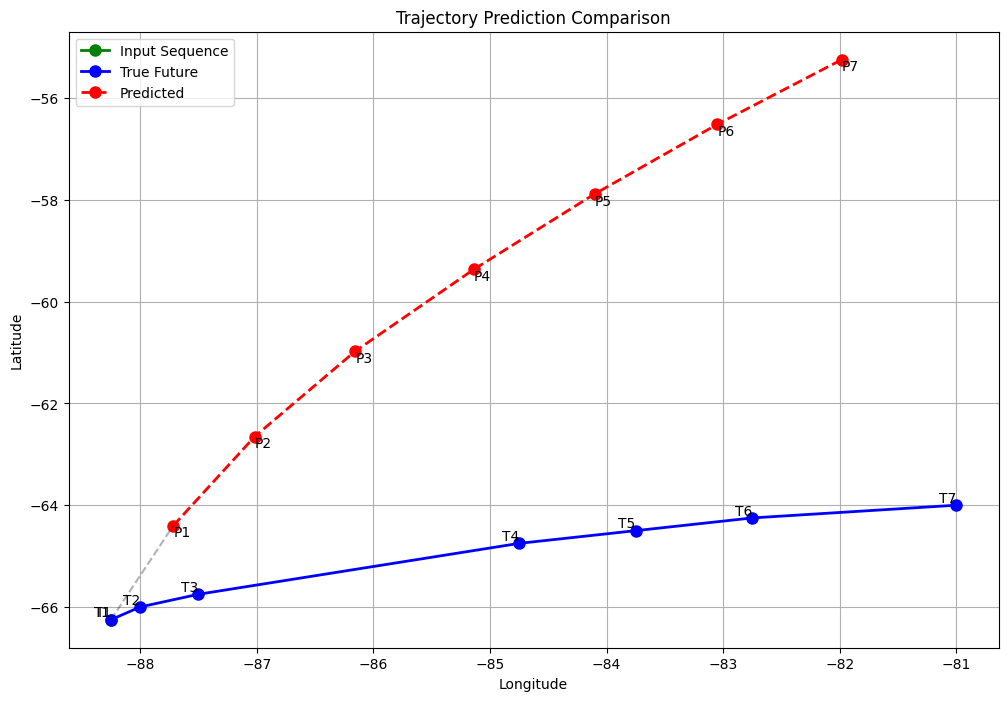

In [ ]:
test_idx = 1244
initial_conditions = X_test[test_idx]  # Shape: (input_steps, n_features)

# Get coordinates (first two features are lon/lat)
input_coords = X_test[test_idx][:, :2]  # Shape: (input_steps, 2)
true_future_coords = y_test[test_idx]  # Shape: (target_steps, 2)

# Combine for complete true trajectory
true_complete_coords = np.vstack([input_coords, true_future_coords])  # Shape: (input_steps + target_steps, 2)

# Make prediction (specify n_features if different from 12)
predicted_coords = predict_trajectory(model, initial_conditions, steps=target_steps)

# Generate the plot
plot_trajectory_comparison(
    true_coords=true_complete_coords,
    predicted_coords=predicted_coords,
    lon_scaler=lon_scaler,
    lat_scaler=lat_scaler,
    input_steps=input_steps,
    target_steps=target_steps
)

In [ ]:
#VERSION WITH HAVERSINE LOSS AND MAE AS LOSSES
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization, Dense
from tensorflow.keras.layers import TimeDistributed, Dropout, Conv1D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras import backend as K

class HaversineLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.R = tf.constant(6371.0, dtype=tf.float64)  # Earth radius in km
        
    def call(self, y_true, y_pred):
        # Ensure float64 conversion
        y_true = tf.cast(y_true, tf.float64)
        y_pred = tf.cast(y_pred, tf.float64)
        
        # Convert to radians
        y_true_rad = y_true * (np.pi / 180.0)
        y_pred_rad = y_pred * (np.pi / 180.0)
        
        # Calculate differences
        dlon = y_pred_rad[..., 0] - y_true_rad[..., 0]
        dlat = y_pred_rad[..., 1] - y_true_rad[..., 1]
        
        # Haversine formula
        a = (tf.sin(dlat/2)**2 + 
            tf.cos(y_true_rad[..., 1]) * tf.cos(y_pred_rad[..., 1]) * tf.sin(dlon/2)**2)
        c = 2 * tf.atan2(tf.sqrt(a), tf.sqrt(1-a))
        
        return self.R * tf.reduce_mean(c)

# 1. Set global float policy to float64
tf.keras.backend.set_floatx('float64')

class L1_64(tf.keras.regularizers.Regularizer):
    def __init__(self, l1=0.01):
        self.l1 = K.cast_to_floatx(l1)
        
    def __call__(self, x):
        return self.l1 * tf.reduce_sum(tf.abs(tf.cast(x, tf.float64)))
        
    def get_config(self):
        return {'l1': float(self.l1)}
    
def build_enhanced_trajectory_model(input_shape, target_steps):
    # Input layer
    inputs = Input(shape=input_shape, dtype=tf.float64, name='input_layer')
    
    # 1. Temporal Convolution
    conv = Conv1D(64, kernel_size=3, activation= 'swish', padding='same', dtype=tf.float64)(inputs)
    conv = LayerNormalization(dtype=tf.float64)(conv)
    
    # 2. Multi-head Self Attention
    attn = MultiHeadAttention(
        num_heads=8, 
        key_dim=64, 
        dropout=0.1, 
        dtype=tf.float64
    )(conv, conv)
    attn = LayerNormalization(dtype=tf.float64)(attn + conv)
    
    # 3. Feature Extraction Branch with L1 regularization
    feat = TimeDistributed(
        Dense(128, activation='swish', 
              kernel_regularizer=L1_64(1e-4),  # Using our custom L1
              dtype=tf.float64)
    )(attn)
    
    feat = Dropout(0.2, dtype=tf.float64)(feat)
    feat = TimeDistributed(
        Dense(64, activation='swish', dtype=tf.float64)
    )(feat)
    
    # Rest of the model remains the same...
    temp = Conv1D(64, kernel_size=5, activation='swish', padding='causal', dtype=tf.float64)(attn)
    temp = LayerNormalization(dtype=tf.float64)(temp)
    
    merged = concatenate([feat, temp], dtype=tf.float64)
    last_steps = merged[:, -target_steps:, :]
    
    outputs = TimeDistributed(
        Dense(2, activation='linear',
              kernel_constraint=tf.keras.constraints.MinMaxNorm(),
              dtype=tf.float64),
        name='output'
    )(last_steps)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
        loss=HaversineLoss(),
        metrics=['mse']
    )
    return model

In [ ]:
#VERSION WITH MAE AND MSE AS LOSSES
'''
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization, Dense
from tensorflow.keras.layers import TimeDistributed, Dropout, Conv1D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Set global float policy to float64
tf.keras.backend.set_floatx('float64')

# Custom L1 Regularizer (unchanged)
class L1_64(tf.keras.regularizers.Regularizer):
    def __init__(self, l1=0.01):
        self.l1 = K.cast_to_floatx(l1)
        
    def __call__(self, x):
        return self.l1 * tf.reduce_sum(tf.abs(tf.cast(x, tf.float64)))
        
    def get_config(self):
        return {'l1': float(self.l1)}

# Custom MAE Loss (Mean Absolute Error)
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

# Custom MSE Loss (Mean Squared Error)
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def build_enhanced_trajectory_model(input_shape, target_steps):
    # Input layer
    inputs = Input(shape=input_shape, dtype=tf.float64, name='input_layer')
    
    # 1. Temporal Convolution (Sigmoid)
    conv = Conv1D(64, kernel_size=3, activation='sigmoid', padding='same', dtype=tf.float64)(inputs)
    conv = LayerNormalization(dtype=tf.float64)(conv)
    
    # 2. Multi-head Self Attention (No activation change; uses built-in softmax)
    attn = MultiHeadAttention(
        num_heads=8, 
        key_dim=64, 
        dropout=0.1, 
        dtype=tf.float64
    )(conv, conv)
    attn = LayerNormalization(dtype=tf.float64)(attn + conv)
    
    # 3. Feature Extraction Branch (All Sigmoid)
    feat = TimeDistributed(
        Dense(128, activation='sigmoid', 
              kernel_regularizer=L1_64(1e-4),
              dtype=tf.float64)
    )(attn)
    
    feat = Dropout(0.2, dtype=tf.float64)(feat)
    feat = TimeDistributed(
        Dense(64, activation='sigmoid', dtype=tf.float64)
    )(feat)
    
    # Temporal Processing Branch (Sigmoid)
    temp = Conv1D(64, kernel_size=5, activation='sigmoid', padding='causal', dtype=tf.float64)(attn)
    temp = LayerNormalization(dtype=tf.float64)(temp)
    
    merged = concatenate([feat, temp], dtype=tf.float64)
    last_steps = merged[:, -target_steps:, :]
    
    # Output layer (Keep linear for regression!)
    outputs = TimeDistributed(
        Dense(2, activation='linear',  # Keep linear for regression
              kernel_constraint=tf.keras.constraints.MinMaxNorm(),
              dtype=tf.float64),
        name='output'
    )(last_steps)
    
    model = Model(inputs, outputs)
    
    # Compile with MAE loss and MSE metric
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
        loss=mae,  # Using MAE as the loss function
        metrics=['mse', 'mae']  # Track both MSE and MAE
    )
    
    return model'
    '''

In [39]:
model1 = build_enhanced_trajectory_model(
    input_shape=(input_steps, X_initial.shape[-1]), 
    target_steps=target_steps
)

history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


627/627 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.2774 - mae: 0.2125 - mse: 0.1633 - val_loss: 0.1231 - val_mae: 0.0821 - val_mse: 0.0396
Epoch 2/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.1192 - mae: 0.0850 - mse: 0.0383 - val_loss: 0.0959 - val_mae: 0.0787 - val_mse: 0.0399
Epoch 3/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.0928 - mae: 0.0793 - mse: 0.0363 - val_loss: 0.0797 - val_mae: 0.0745 - val_mse: 0.0379
Epoch 4/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - loss: 0.0804 - mae: 0.0765 - mse: 0.0368 - val_loss: 0.0770 - val_mae: 0.0758 - val_mse: 0.0384
Epoch 5/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.0743 - mae: 0.0734 - mse: 0.0354 - val_loss: 0.0701 - val_mae: 0.0699 - val_mse: 0.0378
Epoch 6/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.0701 - mae: 0.0700 - mse: 0.0312 - val_loss: 0.0675 - val_mae: 0.0674 - val_mse: 0.0360
Epoch 7/50
627/627 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 0.0671 - mae: 0.0670 - mse: 0.0341 - 

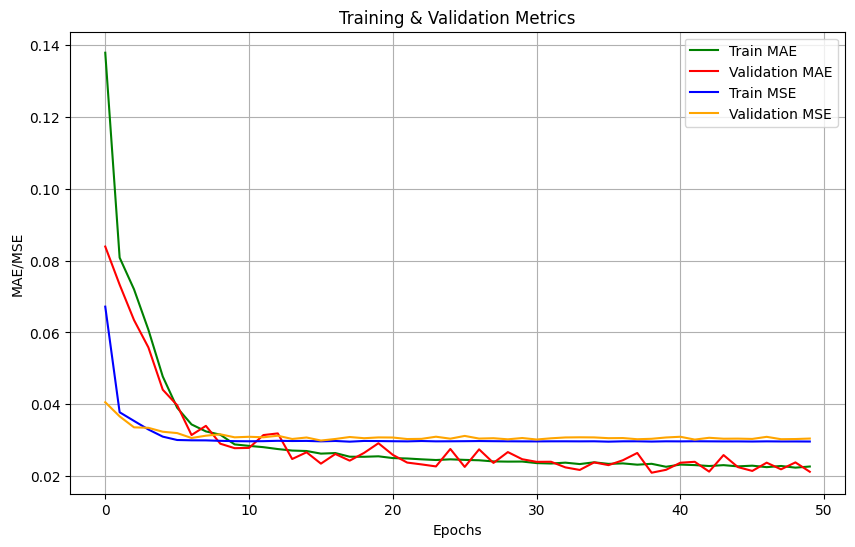

In [ ]:
'''
def plot_all_metrics(history):
    plt.figure(figsize=(10, 6))
    
    # Plot MAE (Train & Validation)
    plt.plot(history.history['mae'], color = 'green', label='Train MAE')
    plt.plot(history.history['val_mae'], color = 'red', label='Validation MAE')
    
    # Plot MSE (Train & Validation)
    plt.plot(history.history['mse'], color = 'b', label='Train MSE')
    plt.plot(history.history['val_mse'], color = 'orange', label='Validation MSE')
    
    plt.title('Training & Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('MAE/MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

# After training, call:
plot_all_metrics(history1)
'''

In [ ]:
model1 = build_enhanced_trajectory_model(input_shape=(input_steps, X_initial.shape[-1]), target_steps=target_steps)

model1.compile(optimizer='adam', loss= HaversineLoss(), metrics=['mse'])

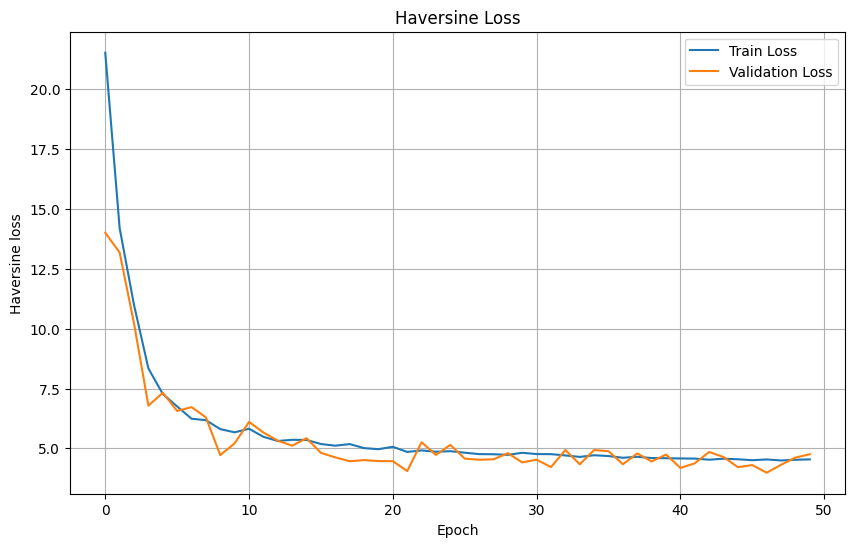

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Haversine Loss')
plt.ylabel('Haversine loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

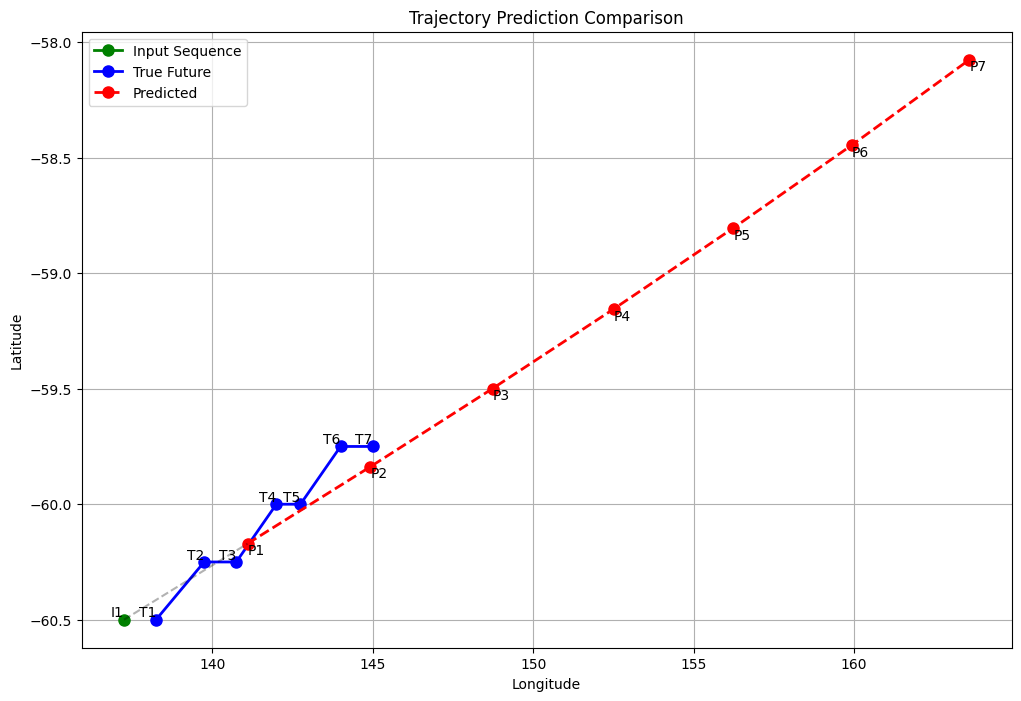

In [35]:
test_idx = 29
initial_conditions = X_test[test_idx]  # Shape: (input_steps, n_features)

# Get coordinates (first two features are lon/lat)
input_coords = X_test[test_idx][:, :2]  # Shape: (input_steps, 2)
true_future_coords = y_test[test_idx]  # Shape: (target_steps, 2)

# Combine for complete true trajectory
true_complete_coords = np.vstack([input_coords, true_future_coords])  # Shape: (input_steps + target_steps, 2)

# Make prediction (specify n_features if different from 12)
predicted_coords = predict_trajectory(model1, initial_conditions, steps=target_steps)


plot_trajectory_comparison(
    true_coords=true_complete_coords,
    predicted_coords=predicted_coords,
    lon_scaler=lon_scaler,
    lat_scaler=lat_scaler,
    input_steps=input_steps,
    target_steps=target_steps
)